In [1]:
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as trans
from PIL import Image
import torchvision.datasets as dsets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
label=pd.read_csv('dog-breed-identification/labelslist.csv',header=None)#加载标签类别号序列对
labelslist=label.values.tolist()[0]
label_dictionary=dict(zip(labelslist,range(120)))

trpiclabels=pd.read_csv('dog-breed-identification/labels.csv')#加载图片标签序列对
trpiclabels=dict(trpiclabels.values.tolist())

tenames=[]

In [3]:
def read_train_data():
    train_image_label=[]
    verify_image_label=[]
    train_transform = trans.Compose([
        trans.ToPILImage(),
        trans.Resize((256, 256)),
        trans.RandomCrop((224, 224)), #训练集中的数据增强操作
        trans.ToTensor()
    ])
    path='dog-breed-identification/train'
    pic=os.listdir(path)#训练图片集
    
    for i in pic:
        name=i.split('.')
        pathpic=path+'/'+i
        img = Image.open(pathpic).convert('RGB')
        img_np = np.array(img)
        img_tensor=train_transform(img_np)
        l=label_dictionary[trpiclabels[name[0]]]
        if random.random()<0.9:
            train_image_label.append((img_tensor,l))
        else:
            verify_image_label.append((img_tensor,l))
    return train_image_label,verify_image_label

In [4]:
def read_test_data():
    test_image_label=[]
    train_transform = trans.Compose([
        trans.ToPILImage(),
        trans.Resize((224, 224)),
        trans.ToTensor()
    ])
    path='dog-breed-identification/test'
    pic=os.listdir(path)#测试图片集
    for i in pic:
        name=i.split('.')
        tenames.append(name[0])
        pathpic=path+'/'+i
        img = Image.open(pathpic).convert('RGB')
        img_np = np.array(img)
        img_tensor=train_transform(img_np)
        test_image_label.append(img_tensor)
    return test_image_label

In [5]:
train_set,verify_set=read_train_data()
test_set=read_test_data()

train_dl = DataLoader(train_set, batch_size = 20, shuffle = True, drop_last = False)
verify_dl = DataLoader(train_set, batch_size = 20, shuffle = True, drop_last = False)
test_dl = DataLoader(test_set, batch_size = 20, shuffle = False, drop_last = False)

In [6]:
print(len(tenames),tenames[0])#测试用

10357 000621fb3cbb32d8935728e48679680e


torch.Size([3, 224, 224]) 37


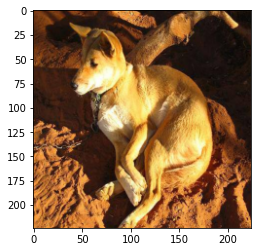

In [7]:
print(train_set[0][0].shape,train_set[0][1])#测试用
plt.imshow(train_set[0][0].detach().numpy().transpose([1,2,0]))

In [2]:
class Bottleneck(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,useds,stride=1):
        super(Bottleneck,self).__init__()
        self.conv1=nn.Conv2d(input_size,hidden_size,1,1,bias=False)
        self.bn1=nn.BatchNorm2d(hidden_size)
        self.conv2=nn.Conv2d(hidden_size,hidden_size,3,stride,1,bias=False)
        self.bn2=nn.BatchNorm2d(hidden_size)
        self.conv3=nn.Conv2d(hidden_size,output_size,1,1,bias=False)
        self.bn3=nn.BatchNorm2d(output_size)
        self.relu=nn.ReLU(inplace=True)
        self.useds=useds
        if useds:
            self.downsample=nn.Sequential(nn.Conv2d(input_size,output_size,1,stride,bias=False),
                                          nn.BatchNorm2d(output_size)
                                         )
    
    def forward(self,x):
        o=self.conv1(x)
        o=self.bn1(o)
        o=self.relu(o)
        o=self.conv2(o)
        o=self.bn2(o)
        o=self.relu(o)
        o=self.conv3(o)
        o=self.bn3(o)
        if self.useds:
            o=o+self.downsample(x)
        o=self.relu(o)
        return o

In [3]:
class myresnet(nn.Module):
    def __init__(self):
        super(myresnet,self).__init__()
        self.conv1=nn.Conv2d(3,64,7,2,3,bias=False)
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU(inplace=True)
        self.maxpool=nn.MaxPool2d(3,2,1,1)
        
        self.layer1=nn.Sequential(Bottleneck(64,64,256,True,1),
                                  Bottleneck(256,64,256,False),
                                  Bottleneck(256,64,256,False)
                                 )
        self.layer2=nn.Sequential(Bottleneck(256,128,512,True,2),
                                  Bottleneck(512,128,512,False),
                                  Bottleneck(512,128,512,False),
                                  Bottleneck(512,128,512,False)
                                 )
        self.layer3=nn.Sequential(Bottleneck(512,256,1024,True,2),
                                  Bottleneck(1024,256,1024,False),
                                  Bottleneck(1024,256,1024,False),
                                  Bottleneck(1024,256,1024,False),
                                  Bottleneck(1024,256,1024,False),
                                  Bottleneck(1024,256,1024,False)
                                 )
        self.layer4=nn.Sequential(Bottleneck(1024,512,2048,True,2),
                                  Bottleneck(2048,512,2048,False),
                                  Bottleneck(2048,512,2048,False)
                                 )
        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Linear(2048,120)
    
    def forward(self,x):
        o=self.conv1(x)
        o=self.bn1(o)
        o=self.relu(o)
        o=self.maxpool(o)
        
        o=self.layer1(o)
        o=self.layer2(o)
        o=self.layer3(o)
        o=self.layer4(o)
        
        o=self.avgpool(o)
        o=o.view(-1,2048)
        o=self.fc(o)
        return o

In [4]:
net=myresnet().to(device)
optimizer = torch.optim.Adam(net.parameters(),lr = 0.0001)
criterion = nn.CrossEntropyLoss()
net

myresnet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [11]:
def eval(model,criterion,dataloader):
    net.eval()#因为使用了dropout，所以需要在评估时用这个函数让网络不再dropout
    loss = 0#预测偏差值
    accuracy = 0#预测准确率
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        logits = model(batch_x)
        error = criterion(logits,batch_y)
        loss += error.item()
        probs,pred_y = logits.data.max(dim = 1)
        accuracy += (pred_y == batch_y.data).sum().double()/batch_y.size(0)
    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss, accuracy

In [12]:
nepochs = 50
for epoch in range(nepochs):
    #net.train()#使dropout发挥作用
    for batch_x,batch_y in train_dl:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = net(batch_x)
        error = criterion(logits,batch_y)#有平均
        error.backward()
        optimizer.step()
    tr_loss, tr_acc = eval(net,criterion,train_dl)
    ve_loss, ve_acc = eval(net,criterion,verify_dl)
    print('NO.%d train error: %.1e, train acc: %.2f\t verify error: %.1e, verify acc: %.2f'%(epoch,tr_loss,tr_acc,ve_loss,ve_acc))

NO.0 train error: 4.7e+00, train acc: 1.95	 verify error: 4.7e+00, verify acc: 1.95
NO.1 train error: 4.7e+00, train acc: 1.63	 verify error: 4.7e+00, verify acc: 1.63
NO.2 train error: 4.7e+00, train acc: 2.08	 verify error: 4.7e+00, verify acc: 2.08


KeyboardInterrupt: 

In [ ]:
a=0
for i in test_dl:
    batch_x=batch_x.to(device)
    logits = net(batch_x)
    result1=nn.functional.softmax(logits)
    if a!=0:
        result=torch.cat([result,result1.detach()],dim=0)
    else:
        result=result1.detach()
        a+=1
result=result.to('cpu').numpy()

In [ ]:
result=result[:-43,:]
#result1.shape
pd.DataFrame(result,tenames,labelslist).to_csv('submit.csv')

In [ ]:
torch.save(net.state_dict(), 'resnet50.pt')